In [73]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [74]:
dataset_path = './sentiment_analysis.csv'
df = pd.read_csv(dataset_path, index_col = 'id')

In [75]:
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r'^RT [\s]+', '', text)

    # Hyperlink removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Hashtags removal
    text = re.sub(r'#', '', text)

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenization
    tokenizer = TweetTokenizer(preserve_case = False, 
                               strip_handles = True, 
                               reduce_len = True)

    text_tokens = tokenizer.tokenize(text)
    return text_tokens

In [76]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']

        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1
    
    return freqs

In [77]:
def get_feature(text, freqs):
    tokens = text_normalize(text)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += freqs[(token, 0)]
        X[2] += freqs[(token, 1)]

    return X

In [78]:
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)

X = np.array(X)
y = np.array(y)

In [79]:
# split train val test
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = val_size,
    random_state = random_state,
    shuffle = is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size = test_size,
    random_state = random_state,
    shuffle = is_shuffle
)

In [80]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [81]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, theta):
    dot_product = np.dot(X, theta)
    return sigmoid(dot_product)

def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)).mean()

def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size 

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    return (y == y_hat).mean()

In [82]:
# initialize hyperparameters and weights
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(size = X_train.shape[1])

In [83]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]
        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)
        gradient = compute_gradient(X_i, y_i, y_hat)
        theta -= gradient * lr
        train_acc = compute_accuracy(X_i, y_i, theta)

        train_batch_losses.append(train_loss)
        train_batch_accs.append(train_acc)

        y_val_hat = predict(X_val, theta)
        val_loss = compute_loss(y_val_hat, y_val)
        val_acc = compute_accuracy(X_val, y_val, theta)
        
        val_batch_losses.append(val_loss)
        val_batch_accs.append(val_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    val_losses.append(val_batch_loss)
    val_accs.append(val_batch_acc)

    print (f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss : {val_batch_loss:.3f}')


EPOCH 1:	Training loss: 0.707	Validation loss : 0.704

EPOCH 2:	Training loss: 0.661	Validation loss : 0.659

EPOCH 3:	Training loss: 0.624	Validation loss : 0.622

EPOCH 4:	Training loss: 0.594	Validation loss : 0.591

EPOCH 5:	Training loss: 0.569	Validation loss : 0.566

EPOCH 6:	Training loss: 0.548	Validation loss : 0.546

EPOCH 7:	Training loss: 0.531	Validation loss : 0.528

EPOCH 8:	Training loss: 0.516	Validation loss : 0.514

EPOCH 9:	Training loss: 0.504	Validation loss : 0.502

EPOCH 10:	Training loss: 0.494	Validation loss : 0.491

EPOCH 11:	Training loss: 0.485	Validation loss : 0.483

EPOCH 12:	Training loss: 0.477	Validation loss : 0.475

EPOCH 13:	Training loss: 0.471	Validation loss : 0.468

EPOCH 14:	Training loss: 0.465	Validation loss : 0.463

EPOCH 15:	Training loss: 0.460	Validation loss : 0.457

EPOCH 16:	Training loss: 0.456	Validation loss : 0.453

EPOCH 17:	Training loss: 0.452	Validation loss : 0.449

EPOCH 18:	Training loss: 0.448	Validation loss : 0.445



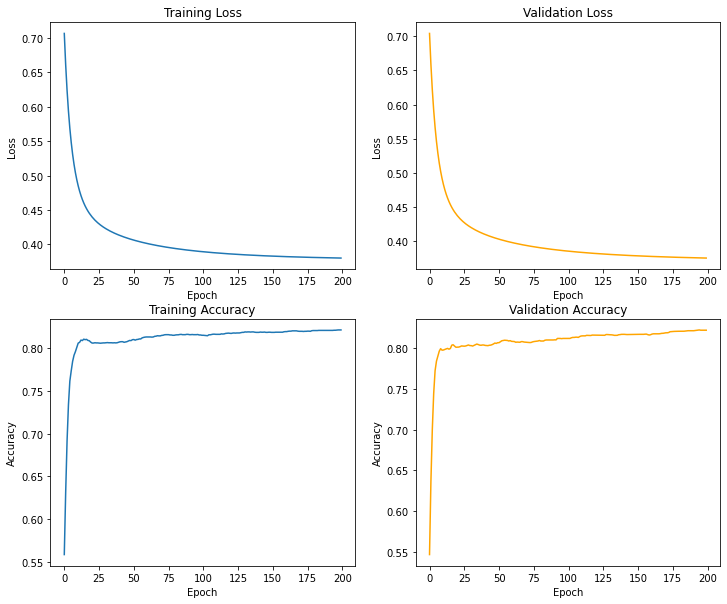

In [84]:
fig, ax = plt.subplots(2, 2, figsize = (12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel = 'Epoch', ylabel = 'Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel = 'Epoch', ylabel = 'Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [85]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set:')
print(f'Accuracy: {val_set_acc}')
print(f'Accuracy: {test_set_acc}')

Evaluation on validation and test set:
Accuracy: 0.821969696969697
Accuracy: 0.8434343434343434
